# 2024-12-02 Rotation Error Plots

This notebook imports `eval_stats.csv` from an experiment and uses functions from `scripts/analyze.py` to calculate rotation error in degrees. 

This notebook will explore some different plotting options for rotation error.

## Single Experiment


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys

sys.path.append(os.path.expanduser("~/tbp/monty_lab"))
from monty_capabilities_analysis.scripts.analyze import (
    get_mean_std_rotation_error_degrees,
)


In [2]:
experiment = "dist_agent_1lm"
results_dir = os.path.expanduser(
    f"~/tbp/monty_lab/monty_capabilities_analysis/results/dmc/{experiment}"
)
eval_stats_path = os.path.join(results_dir, "eval_stats.csv")
eval_stats = pd.read_csv(eval_stats_path)

mean_std_rotation_error_degrees = get_mean_std_rotation_error_degrees(eval_stats)

# the output is a dictionary of all errors, and scalar mean and std rotation error in degrees
print(mean_std_rotation_error_degrees.keys())
print(mean_std_rotation_error_degrees["errors"][:3])
print(mean_std_rotation_error_degrees["mean"])
print(mean_std_rotation_error_degrees["std"])


dict_keys(['errors', 'mean', 'std'])
[4.09430214e-07 1.31670102e-07 2.03648546e-05]
9.461926032117484
34.067984214489904


In [3]:
# Create new dataframe combining the following columns from eval_stats: primary_performance, primary_target_object, most_likely_object and our calculated rotation error in degrees
df = eval_stats[["primary_performance", "primary_target_object", "most_likely_object"]]
df["rotation_error_degrees"] = mean_std_rotation_error_degrees["errors"]
df.head()


/var/folders/5m/qkp7l08j1018xlgy3rl884540000gn/T/ipykernel_27345/2116612234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rotation_error_degrees"] = mean_std_rotation_error_degrees["errors"]


,primary_performance,primary_target_object,most_likely_object,rotation_error_degrees
0,correct,mug,mug,4.094302e-07
1,correct,bowl,bowl,1.316701e-07
2,correct,potted_meat_can,potted_meat_can,2.036485e-05
3,correct,master_chef_can,master_chef_can,6.697379e-08
4,correct,i_cups,i_cups,1.699170e+02


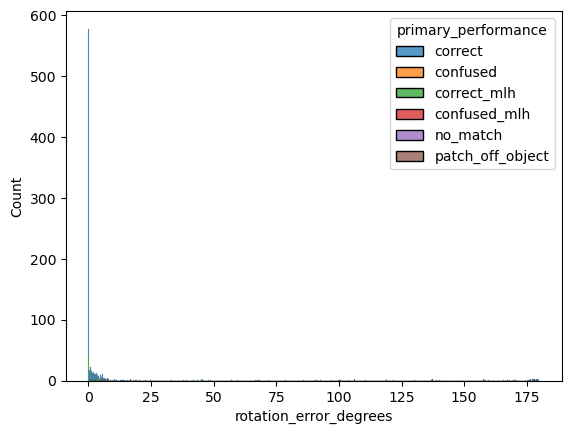

In [9]:
# Plot rotation error histogram grouped by primary_performance
sns.histplot(
    data=df, x="rotation_error_degrees", hue="primary_performance", multiple="stack"
)
plt.show()


/var/folders/5m/qkp7l08j1018xlgy3rl884540000gn/T/ipykernel_27345/2719953834.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="rotation_error_degrees", hue="primary_performance", multiple="stack")


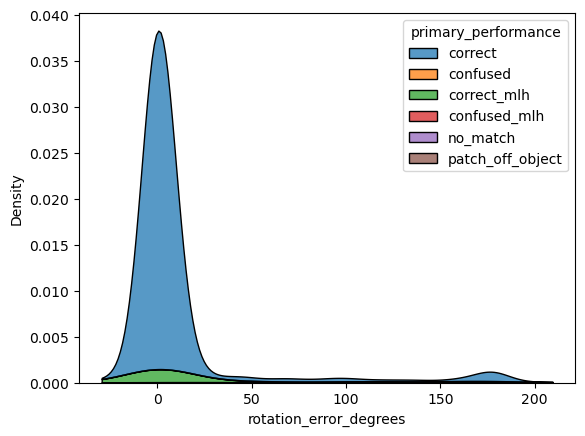

In [12]:
# Let's try KDE plot instead
sns.kdeplot(
    data=df, x="rotation_error_degrees", hue="primary_performance", multiple="stack"
)
plt.show()


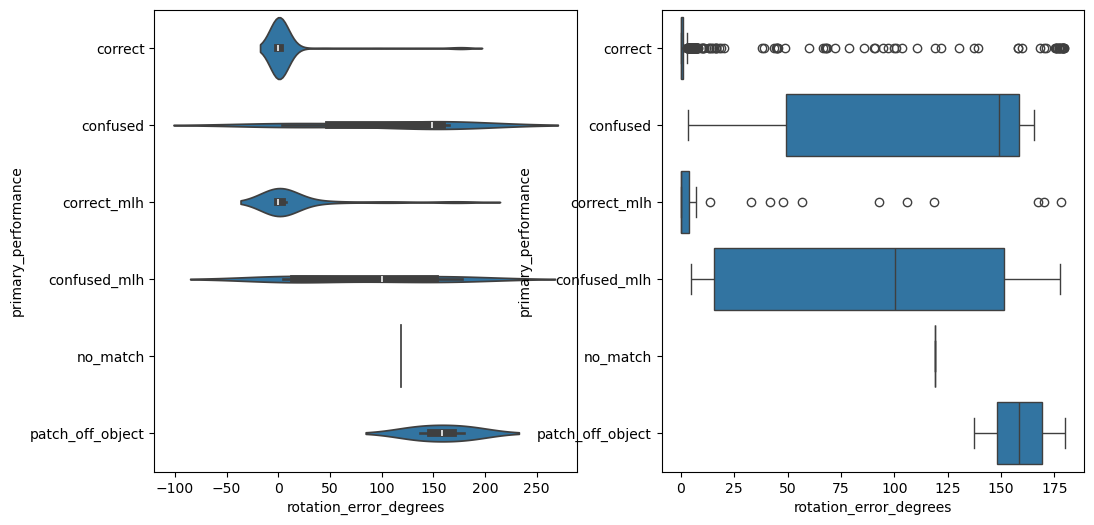

In [20]:
# Better, but still cannot see the "confused" and "confused_mlh" clearly - let's try violin plot and box plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(data=df, x="rotation_error_degrees", y="primary_performance", ax=axes[0])
sns.boxplot(data=df, x="rotation_error_degrees", y="primary_performance", ax=axes[1])
plt.show()


/var/folders/5m/qkp7l08j1018xlgy3rl884540000gn/T/ipykernel_27345/590208838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["primary_performance"] = df_clean["primary_performance"].replace(


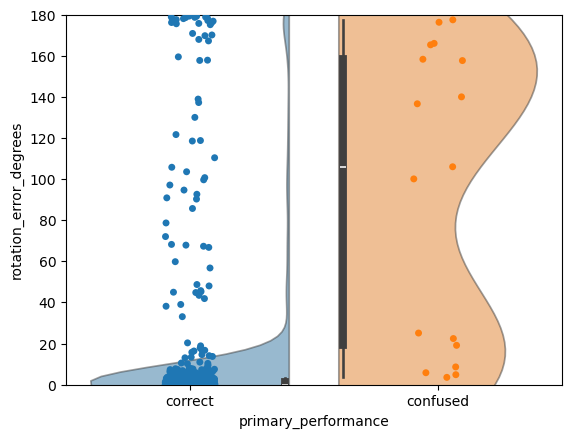

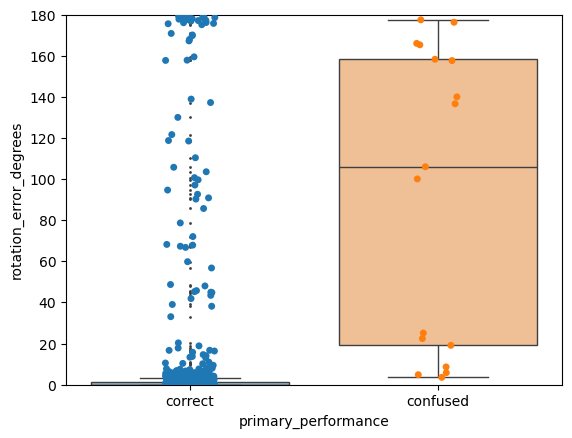

In [45]:
# Better, definitely can "see" that the mean for "confused" and "confused_mlh" are higher than "correct" and "correct_mlh", but not very visually pleasing.
# Let's clean this up a bit by combining correct and correct_mlh together and confused and confused_mlh together.
# I will exclude no_match and patch_off_object for now.

df_clean = df[~df["primary_performance"].isin(["no_match", "patch_off_object"])]
# combine correct and correct_mlh together and confused and confused_mlh together
df_clean["primary_performance"] = df_clean["primary_performance"].replace(
    {"correct_mlh": "correct", "confused_mlh": "confused"}
)

# Make a violin plot where half is from correct and half is from confused, oriented vertically
# Also add some jitter on top of the violin plot to show the distribution
# Since this is rotation error, it should be from [0, 180] degrees.
# Let's set the y-axis limit to be [-10, 190]
sns.violinplot(
    data=df_clean,
    x="primary_performance",
    y="rotation_error_degrees",
    hue="primary_performance",
    split=True,
    alpha=0.5,
)
# Add some jitter on top of the violin plot to show the distribution
sns.stripplot(
    data=df_clean,
    x="primary_performance",
    y="rotation_error_degrees",
    hue="primary_performance",
    jitter=0.1,
)
plt.ylim(0, 180)
plt.show()
# Honestly I like box plot better than violin plot for this case. Make outliers dots smaller.
ax = sns.boxplot(
    data=df_clean,
    x="primary_performance",
    y="rotation_error_degrees",
    hue="primary_performance",
    flierprops={"marker": "o", "markersize": 1},
)
# setting alpha via matplotlib because boxplot() doesn't support it
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))
# add some jitter on top of the box plot to show the distribution
sns.stripplot(
    data=df_clean,
    x="primary_performance",
    y="rotation_error_degrees",
    hue="primary_performance",
    jitter=0.1,
)
plt.ylim(0, 180)
plt.show()


## Multiple Experiments 